<center><h1>Section 5-2A Output Graphics</h1></center>

In [1]:
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import pandas as pd

%matplotlib widget
%matplotlib inline

In [2]:
root_directory = os.path.dirname(os.path.dirname(os.getcwd()))
json_file_list = [
    'processed/RESULTS5-2A-BSIMAC-9-9.0.74.json',
    'processed/RESULTS5-2A-CSE-0.861.1.json',
    'processed/RESULTS5-2A-DeST-2.0-20190401.json',
    'processed/RESULTS5-2A-EnergyPlus-9.0.1.json',
    'processed/RESULTS5-2A-ESP-r-13.3.json',
    'processed/RESULTS5-2A-TRNSYS-18.00.0001.json']

In [3]:
HTML("""
<style>
.jp-RenderedImage {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
json_data = {}
table_df = {}

for f in json_file_list:
    # make the table lookup object
    # 0 - json key name
    # 1 - list to make row index
    table_lookup = [
        ('conditioned_zone_loads_non_free_float', ['program_name', ])
    ]
    file_path = os.path.join(root_directory, f) 
    with open(file_path, 'r') as jf:
        data = json.load(jf)
        # load json objects as objects with the file name as the key
        json_data[str(os.path.basename(f)).replace('.json', '')] = data
        # load each table, if exists into a dataframe of the json key name
        for tbl, row_index in table_lookup:
            tbl_data = data.get(tbl)
            if tbl_data:
                try:
                    table_df[tbl]
                except KeyError:
                    table_df[tbl] = pd.DataFrame()
                # Format the json data to a multiIndex table with a meaningful row index
                tmp_df = pd.json_normalize(tbl_data)
                tmp_df.columns = pd.MultiIndex.from_tuples([i.split('.') for i in tmp_df.columns])
                tmp_df['program_name'] = str(os.path.basename(f)).replace('.json', '')
                tmp_df = tmp_df.set_index(row_index)
                table_df[tbl] = pd.concat([table_df[tbl], tmp_df])

In [5]:
# sample table output

display(HTML(table_df['conditioned_zone_loads_non_free_float'].to_html()))

In [6]:
# sample extraction by index

tst_table = table_df['conditioned_zone_loads_non_free_float']\
    .loc[:, table_df['conditioned_zone_loads_non_free_float']\
    .columns.get_level_values(1) == 'peak_heating_kW'].copy()

display(HTML(tst_table.to_html()))

# sample column name extraction by level
print(table_df['conditioned_zone_loads_non_free_float'].columns.levels[0])
print(table_df['conditioned_zone_loads_non_free_float'].columns.levels[1])

,195,200,210,215,220,230,240,250,270,280,290,300,310,320,395,400,410,420,430,440,450,460,470,600,610,620,630,640,650,660,670,680,685,695,800,810,900,910,920,930,940,950,960,980,985,995
,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW,peak_heating_kW
program_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
RESULTS5-2A-BSIMAC-9-9.0.74,1.802000,2.272000,2.374000,2.521000,2.631000,4.219000,2.431000,2.631000,NaN,NaN,NaN,NaN,NaN,NaN,1.948000,2.559000,3.338000,3.138000,3.300000,NaN,2.989000,3.055000,3.118000,3.255000,3.166000,3.145000,3.252000,4.633000,0.0,2.620000,4.122000,2.126000,3.169000,2.138000,2.957000,NaN,2.551000,2.761000,2.895000,2.968000,3.882000,0.0,NaN,1.693000,2.754000,1.711000
RESULTS5-2A-CSE-0.861.1,1.790699,2.226037,2.628976,2.419998,2.839379,4.132903,2.651430,2.837068,2.611381,2.612247,2.611452,2.614056,2.614876,2.608952,2.157448,2.839379,3.440687,3.256238,3.253884,3.027206,2.978316,2.971353,3.000676,3.020233,3.020759,3.037860,3.039372,4.222460,0.0,2.758312,3.655419,1.777641,3.031857,1.795326,2.777638,2.500136,2.443390,2.469025,2.512426,2.536968,3.051914,0.0,2.132035,1.253790,2.452163,1.369555
RESULTS5-2A-DeST-2.0-20190401,1.799000,2.308000,2.605000,2.520000,2.863000,4.223000,2.685000,2.855000,2.560000,2.568000,2.561000,2.589000,2.592000,2.546000,2.085000,2.863000,3.543000,3.365000,3.360000,3.060000,2.753000,2.980000,2.807000,3.035000,3.039000,3.068000,3.072000,4.658000,0.0,2.798000,3.812000,1.811000,3.054000,1.855000,2.864000,2.512000,2.453000,2.474000,2.513000,2.549000,3.659000,0.0,2.085000,1.382000,2.458000,1.462000
RESULTS5-2A-EnergyPlus-9.0.1,1.794000,2.341000,2.565000,2.478000,2.692000,4.316000,2.507000,2.687000,2.597000,2.602000,2.583000,2.603000,2.580000,2.573000,1.952000,2.692000,3.504000,3.319000,3.316000,3.219000,3.100000,3.091000,3.207000,3.204000,3.192000,3.229000,3.207000,4.559000,0.0,2.831000,3.854000,2.052000,3.223000,2.072000,2.924000,2.749000,2.687000,2.699000,2.770000,2.785000,3.143000,0.0,2.259000,1.538000,2.695000,1.622000
RESULTS5-2A-ESP-r-13.3,1.802000,2.275000,2.671000,2.390000,2.788000,4.160000,2.605000,2.780000,2.748000,2.752000,2.750000,2.766000,2.771000,2.733000,2.090000,2.788000,3.473000,3.290000,3.285000,3.237000,3.042000,3.101000,3.169000,3.228000,3.233000,3.253000,3.259000,4.101000,0.0,2.846000,3.992000,2.022000,3.247000,2.025000,2.840000,2.695000,2.633000,2.684000,2.706000,2.765000,3.122000,0.0,2.201000,1.473000,2.642000,1.560000
RESULTS5-2A-TRNSYS-18.00.0001,1.795922,2.352725,2.749789,2.489373,2.878574,4.315297,2.693093,2.874360,2.843240,2.848681,2.843406,2.853648,2.856311,2.833517,2.161342,2.878574,3.596936,3.411455,3.408816,3.374292,3.037313,3.159670,3.231492,3.358893,3.359502,3.384592,3.387554,4.038541,0.0,2.955183,4.220965,2.114720,3.374427,2.117710,2.966946,2.844655,2.778478,2.799195,2.864274,2.900414,3.404824,0.0,2.300402,1.592139,2.785441,1.661985


Index(['195', '200', '210', '215', '220', '230', '240', '250', '270', '280',
       '290', '300', '310', '320', '395', '400', '410', '420', '430', '440',
       '450', '460', '470', '600', '610', '620', '630', '640', '650', '660',
       '670', '680', '685', '695', '800', '810', '900', '910', '920', '930',
       '940', '950', '960', '980', '985', '995', 'program_name'],
      dtype='object')
Index(['annual_cooling_MWh', 'annual_heating_MWh', 'peak_cooling_day',
       'peak_cooling_hour', 'peak_cooling_kW', 'peak_cooling_month',
       'peak_heating_day', 'peak_heating_hour', 'peak_heating_kW',
       'peak_heating_month', ''],
      dtype='object')


In [7]:
# Fig B8-9
import numpy as np

labels = []
data = []
programs = []
cases = ['395', '430', '600', '610', '620', '630', '640', '650']
for idx, (tst, json_obj) in enumerate(json_data.items()):
    tmp_data = []
    for case in cases:
        tmp_data.append(json_obj['conditioned_zone_loads_non_free_float'][case]['peak_heating_kW'])
    data.insert(idx, tmp_data)
    programs.insert(idx, json_obj['identifying_information']['software_name'])
    
hatches = ['/', '-', 'x', '\\', '//', 'o', '|',  '+', 'O', '.', '*'][:len(data)]

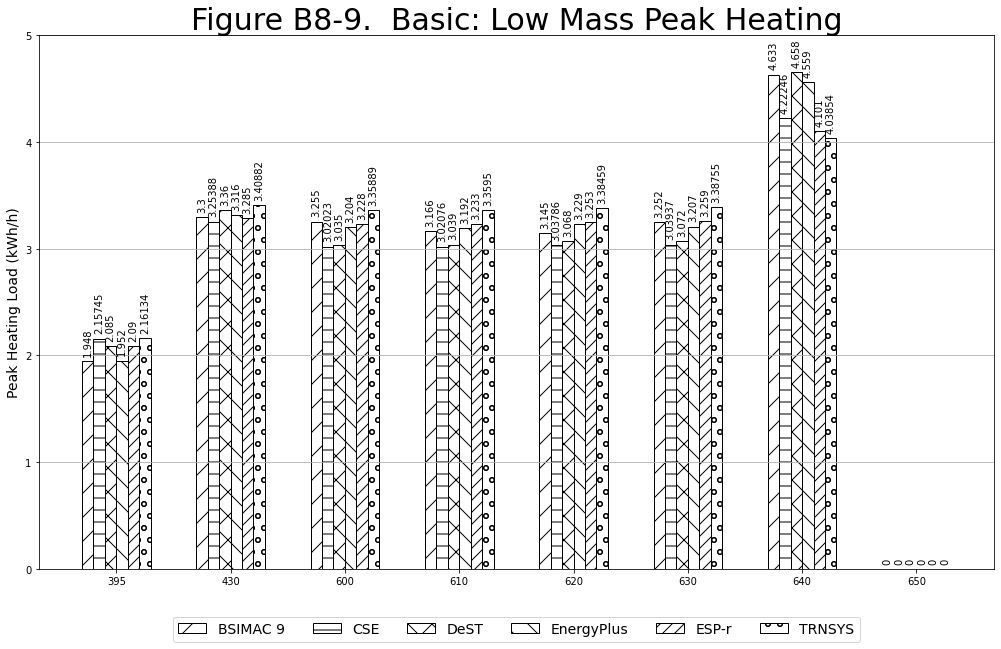

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(14,8))
fig.tight_layout()

width = 0.1

ax.set_xticks(np.arange(max([len(i) for i in data])))
ax.set_title('Figure B8-9.  Basic: Low Mass Peak Heating', fontsize=30)
ax.set_xticklabels(cases)
for idx, (p, d, h) in enumerate(zip(programs, data, hatches)):
    x = np.arange(len(d))
    rects = ax.bar(x + (width * idx) - (width/2 * (len(data) - 1)), d, width, label=p, hatch=h, fill=None)
    ax.bar_label(rects, padding=5, rotation="vertical")


ax.grid(which='major', axis='y')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=len(programs), fontsize=14)
ax.set_ylabel('Peak Heating Load (kWh/h)', fontsize=14)
ax.set_ylim(0, 5)
plt.show();